# Stochastic time-series forecast with Seasonal ARIMA
# Overview
The goal is to find a `stationary` target process (i.e., minimum
temperature here) by removing trend and seasonality to develop the time-series forecast model Seasonal AutoRegressive
Integrated Moving Average (SARIMA). 

Non-stationarity is defined when [unit root](https://en.wikipedia.org/wiki/Unit_root) of the characteristic equation
of the autoregressive model exists, or the less common case when [root is larger than 1](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1468-2354.2010.00625.x).
For now the focused is on unit root test for stationarity.

# Data
[Download](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)
the minimun daily temperature of Melbourne, Australia from 1981 to 1990. Two
years are missing data on 12/31, and are filled in by linear interpolation.
Three days of data value with question marks are removed.

Read the data, rename the variable, add time index, and cast the data type to numeric:

In [180]:
import pandas as pd
series = pd.read_csv('~/Downloads/daily-minimum-temperatures-in-me.csv', error_bad_lines=False)
series.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990':'mint'},inplace=True) # rename minimum temp to 'mint'
y = pd.to_numeric(series["mint"],downcast='float')
y.index = pd.DatetimeIndex(start='1981-01-01',end='1990-12-31',freq='d')


Take the monthly average minimum temperature time-series:

In [ ]:
y = y.resample("M", how='mean') # perform monthly average, this is to avoid freq=365 being too computationally expensive for SARIMAX

Snippet of the data:

In [181]:
print(y.head(10))

1981-01-31    17.712904
1981-02-28    17.678572
1981-03-31    13.500000
1981-04-30    12.356667
1981-05-31     9.490323
1981-06-30     7.306667
1981-07-31     7.577419
1981-08-31     7.238709
1981-09-30    10.143333
1981-10-31    10.087097
Freq: M, Name: mint, dtype: float32


Check the lag correlation to determine how much lag is appropriate:

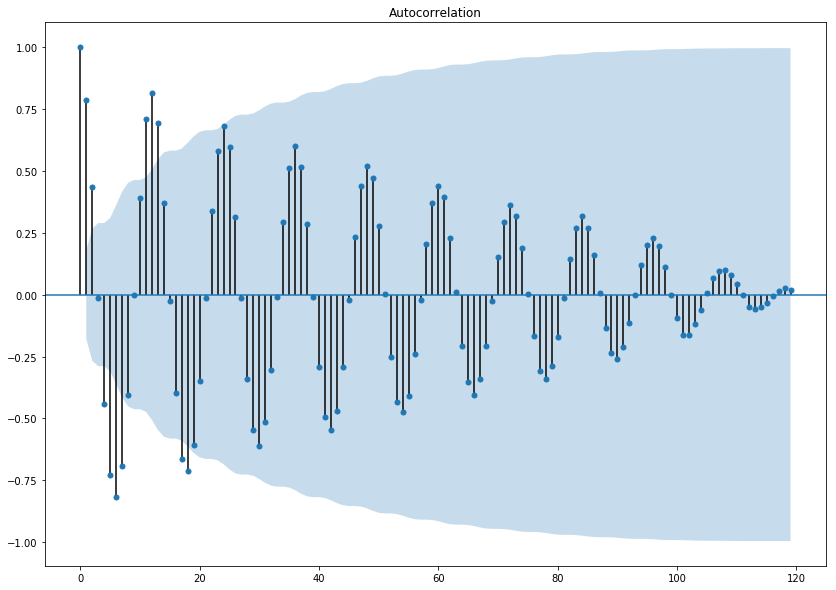

In [182]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
fig = plot_acf(y)
fig.set_size_inches(14,10)
#pyplot.figure(num=None,figsize=(20,12))
pyplot.show()


Notice there are periodic oscillations due to the seasonal cycle.

Decompose the data into trend, season, and residual (first guess of stationary process):

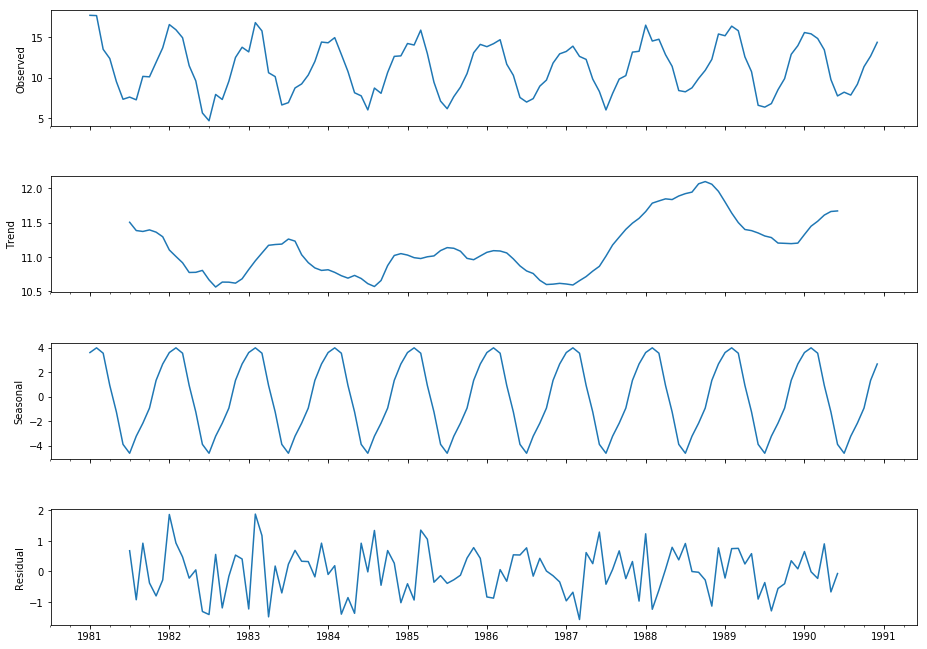

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, model='additive',freq=12) # 365 is the sampling freq (N/T) in a period T=year
# additive model: y[t] = T[t] + S[t] + resid[t]
# seasonal part is filtered out to obtain trend by scipy.signal.convolve, 
# which uses either `direct` or `fft` whichever's faster.
# direct convolution is y(n) = \sum_k x(k)h(n-k), with any given filter h(t), it's directly centering the filter on 
# the point of interest. 
fig = decomposition.plot()
fig.set_size_inches(14,10)
pyplot.show()

Notice the warming trend (seasonal cycle filtered out by convolution filter, i.e, using the default moving average filter with 365 samples), seasonal cycle (daily average taken over 10 years and simply tile-copied for 10 years) and quasi-stationarity of day-to-day residuals (observation - trend - season). 

# Check for stationarity
Consider three differencing cases from SARIMAX: first differencing (remove trend) and seasonal differencing (remove seasonality), and the combined. 


Perform unit root test using Augmented Dickey-Fuller test for stationarity (i.e., null hypothesis assumes non-stationarity with unit root):



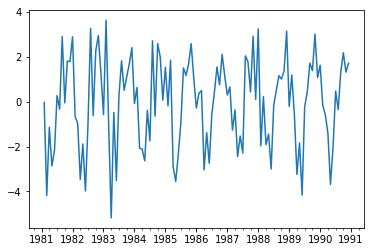

In [189]:
dy1 = y - y.shift(1)
dy1.dropna(inplace=True)
dy1.plot()
pyplot.show()

In [190]:
# y[t] = \r y[t-1] + e[t]
# A unit root is present for the characteristic equation when \r = 1.
# Therefore D Y[t] = (r - 1) y[t-1] + e[t] = d y[t-1] + e[t], and d = 0 becomes the null hypothesis for Dickey-Fuller test for stationarity test.
result_adf = adfuller(dy1)
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.630986
p-value: 0.000113
Critical Values:
	5%: -2.889
	1%: -3.494
	10%: -2.582


This rejects the null hypothesis with well over 99% confidence, therefore lag-1 difference is stationary. 

Let's move on to removing seasonality:

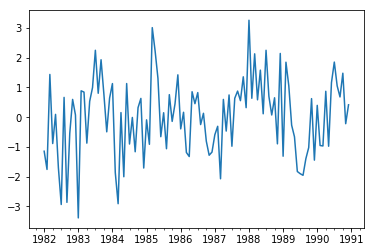

In [200]:
dy12 = y - y.shift(12)
dy12.dropna(inplace=True)
dy12.plot()
pyplot.show()

In [201]:
result_adf = adfuller(dy12)
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.751666
p-value: 0.000067
Critical Values:
	5%: -2.892
	1%: -3.500
	10%: -2.583


So the seasonal 1-lag difference also shows stationarity. 

Let's look at the combined difference:


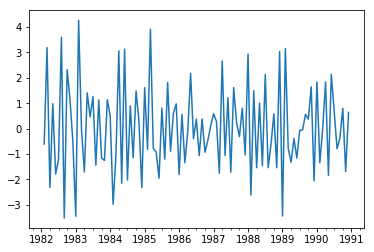

In [203]:
dy112 = dy1 - dy1.shift(12)
dy112.dropna(inplace=True)
dy112.plot()
pyplot.show()

In [205]:
result_adf = adfuller(dy112)
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.777078
p-value: 0.003151
Critical Values:
	5%: -2.893
	1%: -3.502
	10%: -2.583


The combined difference is statistically stationary and the time series show less seasonality than the first difference. Therefore we have a better idea that trend and seasonality are both important.

# Autocorrelation (partial) analysis
Let's look at the autocorrelation and partial autocorrelation to decide how much lag is required: 

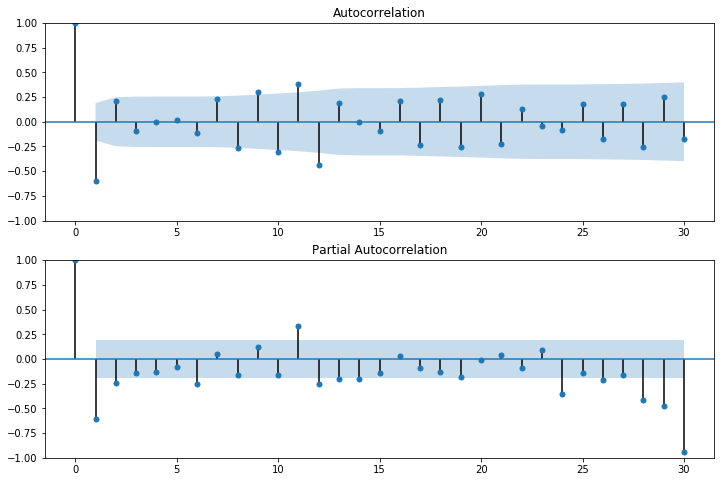

In [226]:
fig = pyplot.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(dy112,lags=30,ax=ax)
pyplot.ylim(-1,1)
ax = fig.add_subplot(212)
fig = plot_pacf(dy112,lags=30,ax=ax)
pyplot.ylim(-1,1)
pyplot.show()

Seems like a 1-day lag is good enough. The partial autocorrelation shows that the lag-2 may not be significant, therefore we expect an AR[1] process.


Let's split the endogenous data into test and validation sets:

In [252]:
#y = decomposition.resid
#y.index = pd.DatetimeIndex(start='1981-01-01',end='1990-12-31',freq='d')
test, valid = y[:12*9], y[12*9:12*10]
test.index, valid.index = y.index[:12*9], y.index[12*9:12*10]


# Build Model
Set up the model hyperparameters
  * (p,d,q): order of the AR parameters, differences, and MA parameters.
  * (P,D,Q,s): Seasonal order of the AR parameters, differences, and MA parameters. P=1 uses the first seasonally offset observation in the model, e.g. t-(s*1) or t-12. P=2, uses the last two seasonally offset observations t-(s*1), t-(s*2). D=1 uses a first order seasonal difference. Q=1 uses a first order errors in the model (e.g. moving average).

In [253]:
# To perform a grid-search use this part
import itertools
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q)) # (p,d,q)
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] # (P,D,Q,s), sampling freq = 365.
seasonal_pdq = [(1, 1, 0, 12)] # no apparent seasons for now

Grid-search for best model by using [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)
:

In [273]:
import warnings
from statsmodels.tsa.arima_model import ARIMA # ARIMA model
from statsmodels.tsa.stattools import adfuller # augmented Dickey-Fuller test
from statsmodels.tsa.statespace.sarimax import SARIMAX # seasonal ARIMA

warnings.filterwarnings("ignore")
aic_min = float("inf")
bic_min = float("inf")
hqic_min = float("inf")
param = (0,0,0,0,0,0) # (p,d,q,P,D,Q,s)
best_model = None # low AIC, BIC is better

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(test, order = x1, seasonal_order = x2, enforce_stationarity = False, enforce_invertibility = False)
              # enforce_stationarity: Whether or not to transform the AR parameters to enforce stationarity in the autoregressive component of the model.
              # enforce_invertibility: Whether or not to transform the MA parameters to enforce invertibility in the moving average component of the model.
            results = mod.fit() # this stage is slow if seasonality is set to s=365 for the original data
            print("(p,d,q,P,D,Q,s) = {}: AIC = {}, BIC = {}, HQIC = {}".format(x1 + x2, results.aic, results.bic, results.hqic))
            if results.aic < aic_min and results.bic < bic_min and results.hqic < hqic_min:
                aic_min = results.aic
                bic_min = results.bic
                hqic_min = results.hqic
                param = x1 + x2
                best_model = mod
        except:
            continue

(p,d,q,P,D,Q,s) = (0, 0, 0, 1, 1, 0, 12): AIC = 266.89846803096464, BIC = 271.7601016286513, HQIC = 268.85280381509557
(p,d,q,P,D,Q,s) = (0, 0, 1, 1, 1, 0, 12): AIC = 266.87718067077515, BIC = 274.1696310673051, HQIC = 269.8086843469715
(p,d,q,P,D,Q,s) = (0, 0, 2, 1, 1, 0, 12): AIC = 261.25329622371055, BIC = 270.9765634190838, HQIC = 265.1619677919724
(p,d,q,P,D,Q,s) = (0, 0, 3, 1, 1, 0, 12): AIC = 263.0660357506697, BIC = 275.2201197448863, HQIC = 267.95187521099706
(p,d,q,P,D,Q,s) = (0, 1, 0, 1, 1, 0, 12): AIC = 298.31316812481975, BIC = 303.15084934041295, HQIC = 300.2566775478318
(p,d,q,P,D,Q,s) = (0, 1, 1, 1, 1, 0, 12): AIC = 267.27165799137134, BIC = 274.52817981476113, HQIC = 270.18692212588945
(p,d,q,P,D,Q,s) = (0, 1, 2, 1, 1, 0, 12): AIC = 269.26561866068613, BIC = 278.9409810918725, HQIC = 273.1526375067103
(p,d,q,P,D,Q,s) = (0, 1, 3, 1, 1, 0, 12): AIC = 264.74675910811055, BIC = 276.84096214709353, HQIC = 269.60553266564074
(p,d,q,P,D,Q,s) = (0, 2, 0, 1, 1, 0, 12): AIC = 38

Show the best model hyperparameter:

In [274]:
print("Best (p,d,q,P,D,Q,s) =", param)

Best (p,d,q,P,D,Q,s) = (3, 0, 0, 1, 1, 0, 12)


The grid-search shows that a lag-3 AR is the best model according to AIC.

Show the statistics of the best model:

In [275]:
results = best_model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1378      0.108      1.276      0.202      -0.074       0.349
ar.L2          0.3597      0.105      3.416      0.001       0.153       0.566
ar.L3         -0.0077      0.090     -0.086      0.932      -0.185       0.169
ar.S.L12      -0.4741      0.095     -4.986      0.000      -0.660      -0.288
sigma2         0.9695      0.140      6.930      0.000       0.695       1.244


z-scores of the regression coefficients are significant above 95% confidence level except for the lag-3 coefficient. 

Show the residual between true and prediction:

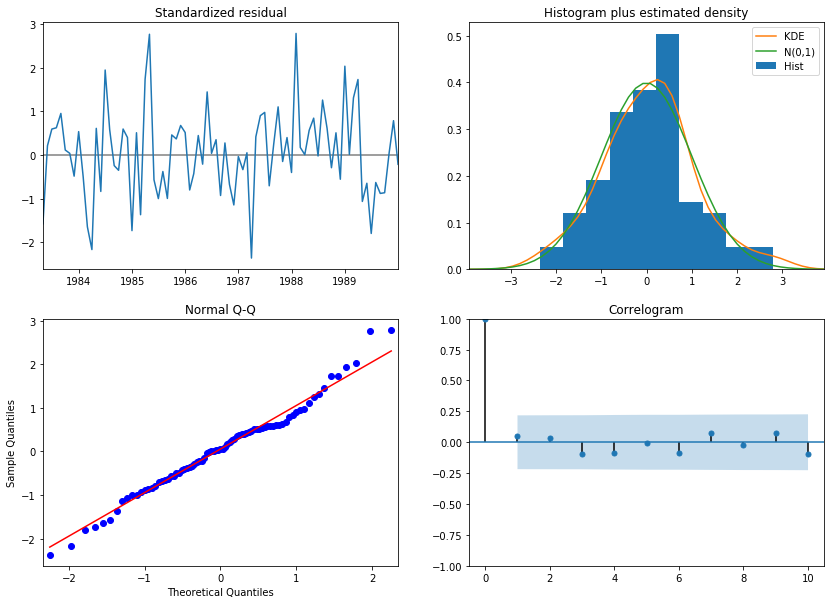

In [276]:
fig = pyplot.figure(figsize=(14,10))
fig = results.plot_diagnostics(fig=fig) # this step is to avoid duplicated plots (a bug)

The zero-centered process, histogram and Q-Q plots indicate the residuals are quasi-normally distributed with zero-mean. Correlogram shows that residuals are uncorrelated.


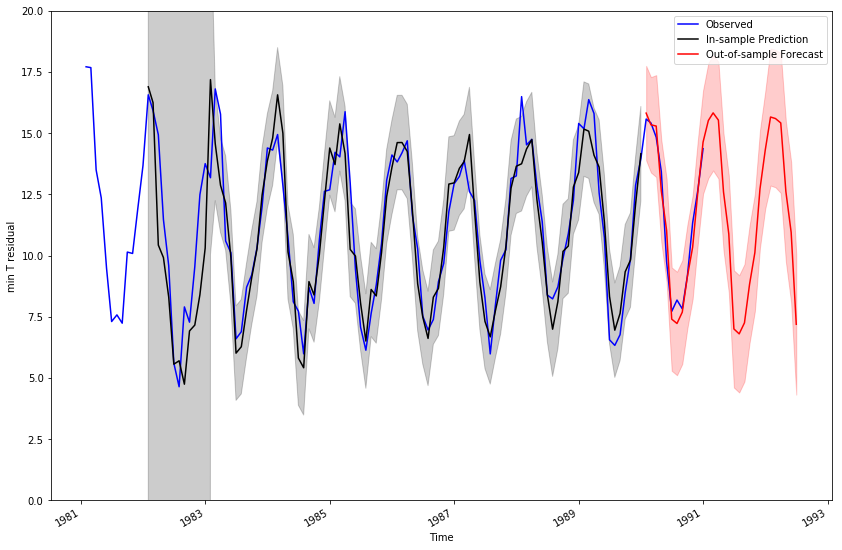

RMSE forecasted = 0.6228445279235597


In [296]:
pred = results.get_prediction(start = test['1982-01':].index[0],  dynamic=False) 
# `dynamic` tells the model when to cut off the observed data for the purpose of forecasting.
pred_ci = pred.conf_int() # 95% confidence interval 
forecast = results.get_forecast(steps=30) # forecast for the next 3 years
forecast_ci = forecast.conf_int() # 95% confidence interval 

fig, ax = pyplot.subplots(figsize=(14, 10))

ax.plot(y['1981-01':'1991-01'].index, y['1981-01':'1991-01'], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('min T residual')
pyplot.ylim(0,20)
pyplot.legend()
pyplot.show()
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(valid['1990-01':'1990-12'], forecast.predicted_mean['1990-01':'1990-12']))
print('RMSE forecasted = '+str(rms))

Out of sample mean is forecasted to be closely following the observation (low RMSE) for the validation period.

# Summary
SARIMAX is shown to capture the seaonality and month-to-month fluctuation. The 1-lag differencing is not selected, showing that the warming trend is not necessary for near term forecast.  

# References
* [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)
* [augmented Dickey-Fuller theory](http://support.sas.com/documentation/cdl/en/etsug/63939/HTML/default/viewer.htm#etsug_macros_sect007.htm)
* [explosive process](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1468-2354.2010.00625.x)
* [exog, endog, what's that?](https://www.statsmodels.org/stable/endog_exog.html)
* Introductory Time Series with R, 2009.
* [minimum temperature data](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)
* [reference project (SF crime)](https://github.com/liyenhsu/SF-Crime-Analysis/blob/master/sf_crime_analysis.ipynb?fbclid=IwAR1sqdDd2izosGw6axuYoGei3288ab-lBgvS6LfDyaeJ8IWzFkNmGtm1cZ4)
* [reference project (min T)](https://machinelearningmastery.com/make-sample-forecasts-arima-python/)
* [SARIMA parameters](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
* [SARIMAX.fit() theory](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html#statsmodels.tsa.statespace.sarimax.SARIMAX.fit)
* [seasonal ARIMA (SARIMAX)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
* [seasonal_decomposition](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)
* [source code for SARIMAX](https://www.statsmodels.org/dev/_modules/statsmodels/tsa/statespace/sarimax.html#SARIMAXResults.get_prediction)
* [unit root](https://en.wikipedia.org/wiki/Unit_root)
* [why is out-of-sample forecast a straight line?](https://github.com/statsmodels/statsmodels/issues/3852?fbclid=IwAR2Gm6l4yI-gR889XLzVeRkkrPP4pL-esPyTHUUtB8dwJuR1BdDpchx_0bw)